# 引入包

In [9]:
import  torch
import  torch.nn as nn
import  torch.nn.functional as F
import  numpy
import random
from torchvision import transforms
from PIL import Image
import os
from torch.utils.data import  Dataset,random_split,DataLoader
from numpy import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

# 超参数

In [10]:
batch_size = 158
lr = 0.001
epoch_num = 50 
num_work = 2

# 加载数据集合

In [11]:
class MyDataset(Dataset):
    def __init__(self, data_path, transform=None, train=True):

        self.data_path = data_path
        self.transform = transform
        self.label_folder = os.listdir(self.data_path)
        self.file = []
        for str in self.label_folder:
            st = os.path.join(self.data_path, str)
            my = os.listdir(st)
            random.shuffle(my)
            t = my[int(len(my) * 0.7):]
            if train:
                t = my[:int(len(my) * 0.7)]

            for index in t:
                self.file.append(os.path.join(st, index))

    def __len__(self):
        return len(self.file)

    def __getitem__(self, idx):

        # 读取图像和标签文件
        image = Image.open(self.file[idx])
        label = os.path.split(os.path.dirname(self.file[idx]))[-1]
        # 数据转换
        if self.transform:
            image = self.transform(image)

        return image, torch.eye(3)[self.label_folder.index(label)]


transform = transforms.Compose([
    transforms.Resize((80, 80)),

    transforms.ToTensor(),
])

# 创建自定义数据集
TrainDataset = MyDataset(data_path=r'/kaggle/input/d/ghostv7788221/expersion03/train',
                         transform=transform
                         , train=True)
TestDataset = MyDataset(data_path=r'/kaggle/input/d/ghostv7788221/expersion03/train',
                        transform=transform
                        , train=False)
print(TrainDataset.__len__(), TestDataset.__len__())

948 409


# 定义网络

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )

        self.fc = nn.Linear(512, 3)

    def forward(self, x):
        out = self.conv(x)
        out = nn.functional.avg_pool2d(out, 32)
        out = out.squeeze()
        out = self.fc(out.view(batch_size, -1))
        out = F.softmax(out, dim=1)
        return out

# 训练与超参数

In [13]:
import time
net = Net().to(device)
train_loss=[]
train_acc=[]
test_loss=[]
test_acc=[]
opt = torch.optim.Adam(net.parameters(), lr=lr)
train_loader = DataLoader(TrainDataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TestDataset, batch_size=batch_size, shuffle=False)
loss = nn.CrossEntropyLoss()
start_time = time.time()
for epoch in range(epoch_num):
    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []
    for x, y in train_loader:
        y_hat = net(x.to(device))
        l = loss(y_hat.view(-1), y.view(-1).to(device))
        acc = 0
        y_index = torch.argmax(y_hat, dim=1)
        Y = torch.argmax(y, dim=1)
        for i in range(len(y_index)):
            if y_index[i] == Y[i]:
                acc += 1
        train_acc_list.append(acc/len(y_index))
        opt.zero_grad()
        l.backward()
        train_loss_list.append(l.item())
        opt.step()

    for x, y in test_loader:

        if(x.size()[0]<batch_size):
            continue
        y_hat = net(x.to(device))

        l = loss(y_hat.view(-1), y.view(-1).to(device))
        # print(l)
        acc = 0
        y_index = torch.argmax(y_hat, dim=1)
        Y = torch.argmax(y, dim=1)
        for i in range(len(y_index)):
            if y_index[i] == Y[i]:
                acc += 1
        test_acc_list.append(acc/len(y_index))
        test_loss_list.append(l.item())
        # print("done")
    train_loss_mean = numpy.mean(train_loss_list)
    train_acc_mean=numpy.mean(train_acc_list)
    train_loss.append(train_loss_mean)
    train_acc.append(train_acc_mean)
    test_loss_mean=numpy.mean(test_loss_list)
    test_acc_mean=numpy.mean(test_acc_list)

    test_loss.append(test_loss_mean)
    test_acc.append(test_acc_mean)
    print("epoch:",epoch+1,
          "\n",
          "train_loss:",train_loss_mean,'train_acc',train_acc_mean,
           "\n",
          "test_loss:", test_loss_mean, 'test_acc',test_acc_mean
          )
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

epoch: 1 
 train_loss: 944.3192138671875 train_acc 0.669831223628692 
 test_loss: 948.0894470214844 test_acc 0.5917721518987342
epoch: 2 
 train_loss: 926.0810038248698 train_acc 0.7837552742616034 
 test_loss: 940.1626586914062 test_acc 0.6708860759493671
epoch: 3 
 train_loss: 919.5369466145834 train_acc 0.8248945147679324 
 test_loss: 934.5684814453125 test_acc 0.7436708860759493
epoch: 4 
 train_loss: 915.2372334798177 train_acc 0.8481012658227849 
 test_loss: 932.0978393554688 test_acc 0.7341772151898734
epoch: 5 
 train_loss: 912.7845967610677 train_acc 0.8544303797468354 
 test_loss: 929.8093872070312 test_acc 0.75
epoch: 6 
 train_loss: 911.2870890299479 train_acc 0.8618143459915611 
 test_loss: 927.594970703125 test_acc 0.7563291139240507
epoch: 7 
 train_loss: 910.1255187988281 train_acc 0.8660337552742616 
 test_loss: 925.1300659179688 test_acc 0.7658227848101266
epoch: 8 
 train_loss: 908.8131612141927 train_acc 0.8681434599156118 
 test_loss: 923.7941284179688 test_acc 0.7

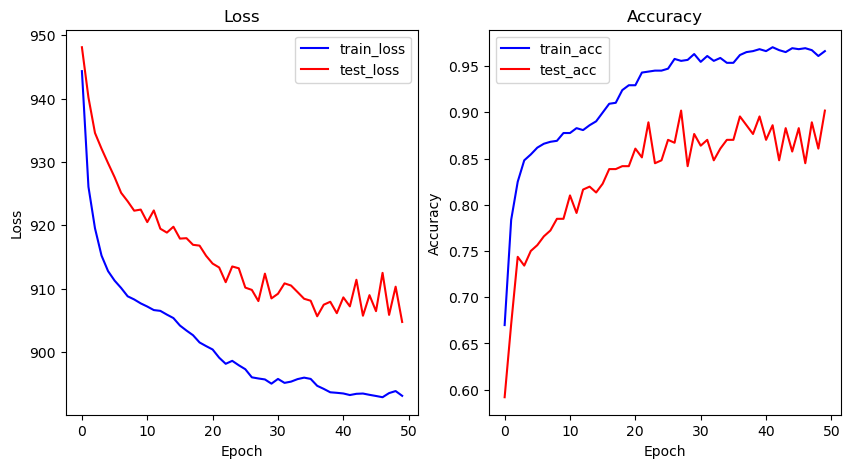

In [14]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

plt.plot(train_loss, 'b-',label="train_loss")
plt.plot(test_loss, 'r-' ,label="test_loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc, 'b-',label="train_acc")
plt.plot(test_acc, 'r-' ,label="test_acc")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()